# TATA Online Retail Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install kagglehub


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import kagglehub
kagglehub.login()
#export KAGGLE_USERNAME="sairithinchakka"
#export KAGGLE_KEY="1e08c5be3caa3b6caae533dcb2fdcddb"

## Download the latest version

In [4]:
# Download latest version
#path = kagglehub.dataset_download("ishanshrivastava28/tata-online-retail-dataset", force_download=True)
#print("Path to dataset files:", path)

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
df = pd.read_csv(r"C:\Users\sairi\.cache\kagglehub\datasets\ishanshrivastava28\tata-online-retail-dataset\versions\1/Online Retail Data Set.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [7]:
# Find duplicate rows
duplicates = df[df.duplicated()]
print(duplicates)

original_row_count = df.shape[0]
print(original_row_count)

# Remove duplicates from the dataset
df= df.drop_duplicates()

# Display the number of rows before and after removing duplicates to confirm changes
cleaned_row_count = df.shape[0]
print(cleaned_row_count)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

             InvoiceDate  UnitPrice  CustomerID         Country  
517     01-12-2010 11:45       1.

In [8]:
df.describe()    

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,536641.000000,536641,536641.000000,401604.000000
mean,9.620029,2011-07-04 08:57:06.087421952,4.632656,15281.160818
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 10:52:00,1.250000,13939.000000
50%,3.000000,2011-07-19 14:04:00,2.080000,15145.000000
75%,10.000000,2011-10-18 17:05:00,4.130000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,219.130156,NaN,97.233118,1714.006089


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


In [10]:
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
# Precompute mode-based descriptions for each StockCode
description_impute = df.groupby('StockCode')['Description'].apply(lambda x: x.mode()[0] if not x.mode().empty else "Unknown Item")

# Fill missing descriptions
df['Description'] = df['Description'].fillna(df['StockCode'].map(description_impute))

# Checking for missing values after handling
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [12]:
summary_stats = df.describe()
manual_stats = {
    "count": df.count(),
    "mean": df.mean(numeric_only=True),
    "std": df.std(numeric_only=True),
    "min": df.min(numeric_only=True),
    "25%": df.quantile(0.25, numeric_only=True),
    "50%": df.median(numeric_only=True),
    "75%": df.quantile(0.75, numeric_only=True),
    "max": df.max(numeric_only=True),
}

# Convert manual_stats to a DataFrame for comparison
manual_stats_df = pd.DataFrame(manual_stats)

# Validate that the two outputs match
validation = summary_stats.equals(manual_stats_df)

# Print Results
if validation:
    print("Test Passed: Summary statistics match the manually computed statistics.")
else:
    print("Test Failed: Discrepancies found in summary statistics.")
    print("\nGenerated Statistics:")
    print(summary_stats)
    print("\nManually Computed Statistics:")
    print(manual_stats_df)

Test Failed: Discrepancies found in summary statistics.

Generated Statistics:
            Quantity                    InvoiceDate      UnitPrice  \
count  401604.000000                         401604  401604.000000   
mean       12.183273  2011-07-10 12:08:23.848567552       3.474064   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-29 15:40:00       1.950000   
75%        12.000000            2011-10-20 11:58:30       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       250.283037                            NaN      69.764035   

          CustomerID  
count  401604.000000  
mean    15281.160818  
min     12346.000000  
25%     13939.000000  
50%     15145.000000  
75%     16784.000000  
max     18287.000000  
std      1714.006089  

Manually Computed Statistics:
              count          mean          std      

In [13]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
list_cols=list(df.columns)
numerical_cols=[]
for i in list_cols:
    if df[i].dtype!='object':
        numerical_cols.append(i)

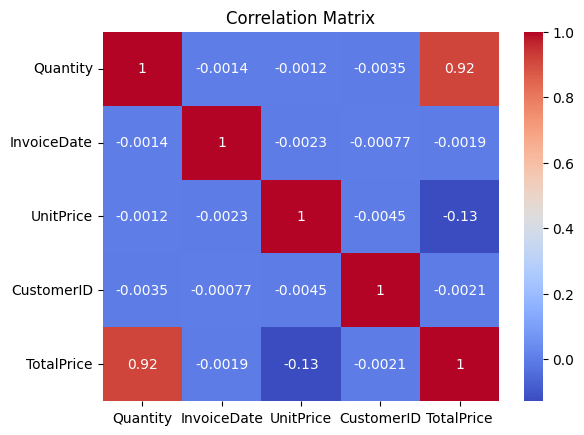

In [14]:
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

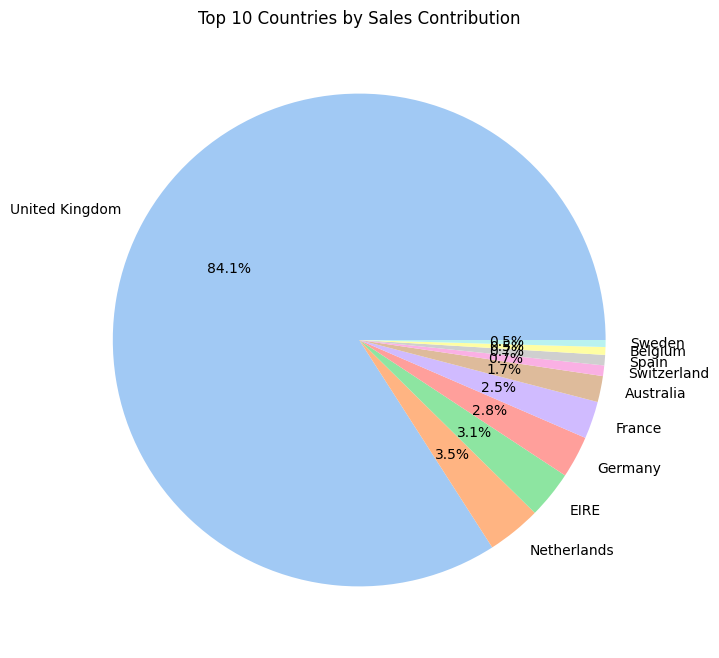

In [15]:
# Regional Analysis
# Group by 'Country' and calculate total sales
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Plot the top 10 countries in a pie chart
country_sales.head(10).plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=sns.color_palette('pastel'))
plt.title('Top 10 Countries by Sales Contribution')
plt.ylabel('')  
plt.show()

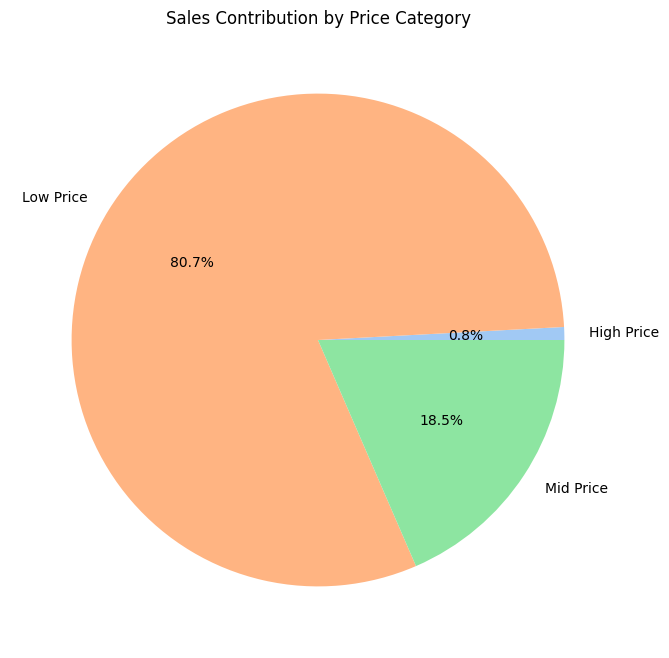

In [16]:
# Categorical Segmentation
# Categorize products into price ranges
def categorize_price(price):
    if price < 5:
        return 'Low Price'
    elif 5 <= price <= 20:
        return 'Mid Price'
    else:
        return 'High Price'

df['PriceCategory'] = df['UnitPrice'].apply(categorize_price)

# Group by new category
price_category_sales = df.groupby('PriceCategory')['TotalPrice'].sum()

# Plot the price category sales in a pie chart
price_category_sales.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=sns.color_palette('pastel'))
plt.title('Sales Contribution by Price Category')
plt.ylabel('')
plt.show()

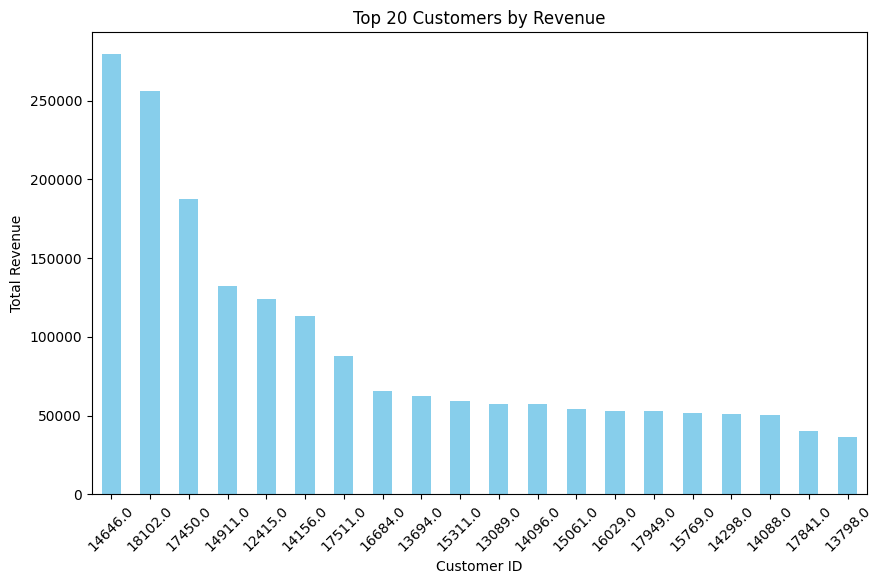

In [17]:
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(20)
top_customers.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Customers by Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Extract time-based features
# Extracting weekday name
df['WeekDay'] = df['InvoiceDate'].dt.strftime('%a')

# Extracting day
df['Day'] = df['InvoiceDate'].dt.day

# Extracting month
df['Month'] = df['InvoiceDate'].dt.month

# Extracting Year
df['Year'] = df['InvoiceDate'].dt.year

#Removing -ve values from dataset 
df= df[(df['Quantity']>0) & (df['UnitPrice']>0)] 

#Derived column
df['TotalAmount'] = df['Quantity']*df['UnitPrice']

# univariate Analysis


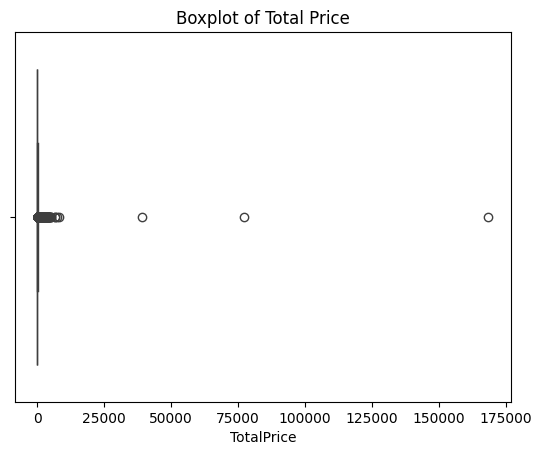

In [19]:
sns.boxplot(x=df['TotalPrice'])
plt.title('Boxplot of Total Price')
plt.show()

## Analysing Year,Month,Day Featur

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,PriceCategory,WeekDay,Day,Month,Year,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Low Price,Wed,1,12,2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Low Price,Wed,1,12,2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34


<Axes: xlabel='Year', ylabel='count'>

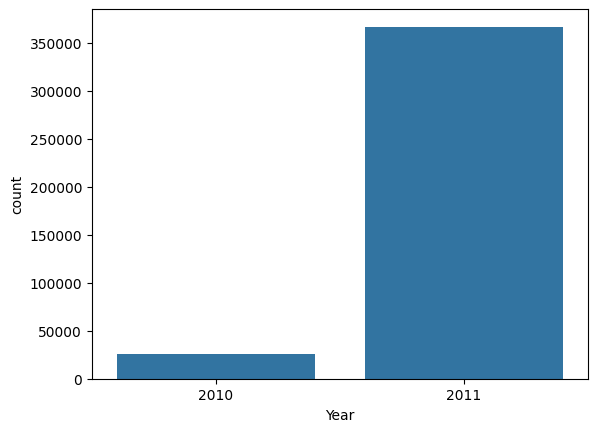

In [21]:
sns.countplot(df,x='Year') 

<Axes: xlabel='Month', ylabel='count'>

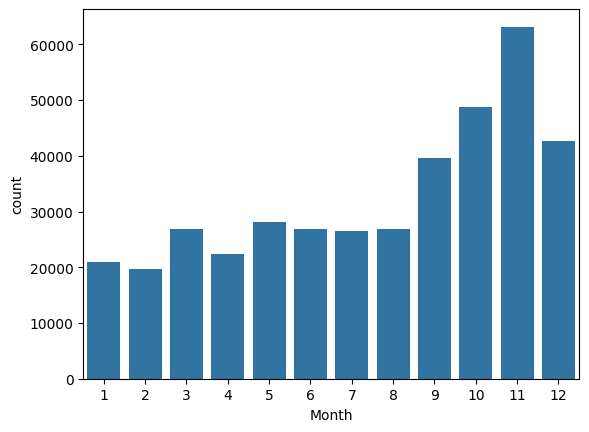

In [22]:
sns.countplot(df,x='Month')

<Axes: xlabel='WeekDay', ylabel='count'>

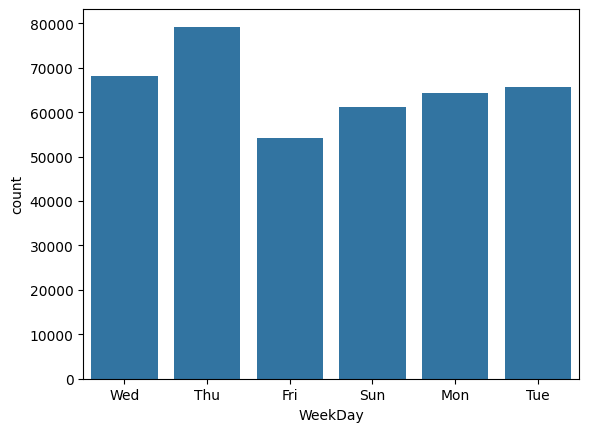

In [23]:
sns.countplot(df,x='WeekDay')

# bivariate Analysis

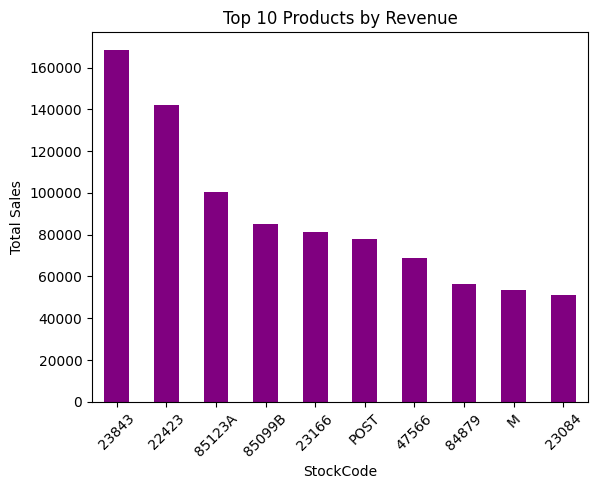

In [24]:
product_sales = df.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False)

product_sales.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Products by Revenue')
plt.xlabel('StockCode')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

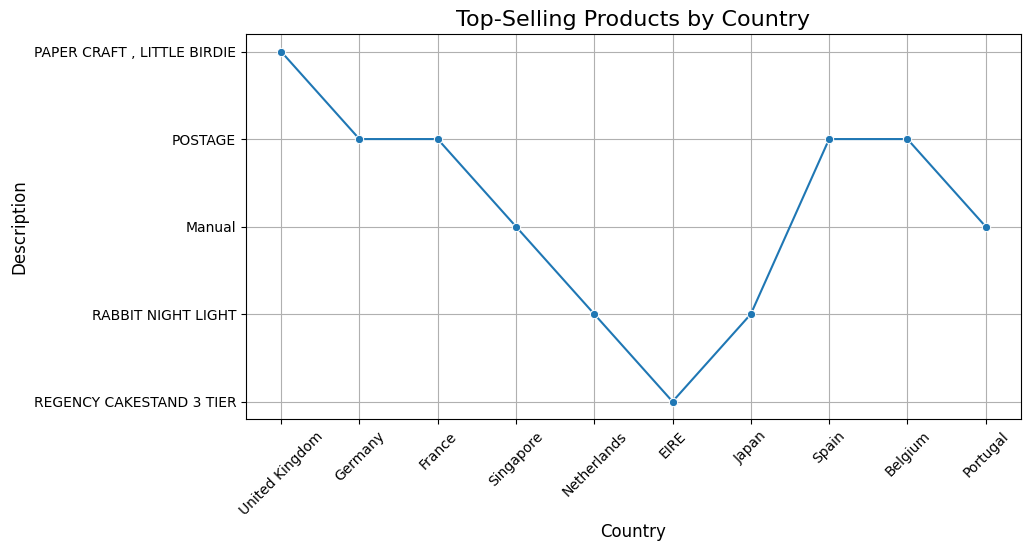

In [25]:
# Identify the top-selling product in each country
top_selling_products = (
    df.groupby(['Country', 'Description'])
    .agg({'TotalPrice': 'sum'})
    .reset_index()
    .sort_values(['Country', 'TotalPrice'], ascending=[True, False])
    .drop_duplicates(subset=['Country'], keep='first')
)

# Sort data for better visualization
top_selling_products_sort = top_selling_products.sort_values(by='TotalPrice', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=top_selling_products_sort,
    x='Country',        
    y='Description', 
    marker='o'       
)

plt.title('Top-Selling Products by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Description', fontsize=12)
plt.xticks(rotation=45) 
plt.grid()
plt.show()


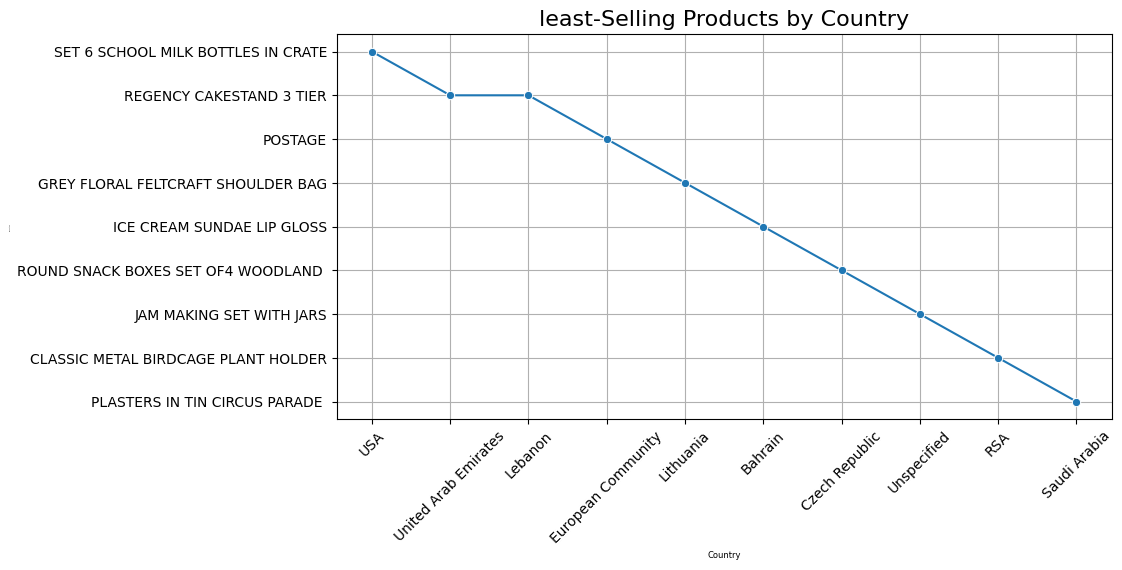

In [26]:
least_selling_products_sort = top_selling_products.sort_values(by='TotalPrice', ascending=False).tail(10)
# Create a line plot with descriptions
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=least_selling_products_sort,
    x='Country',        
    y='Description', 
    marker='o'       
)

plt.title('least-Selling Products by Country', fontsize=16)
plt.xlabel('Country', fontsize=6)
plt.ylabel('Description', fontsize=1)
plt.xticks(rotation=45) 

# Show plot
plt.grid()
plt.show()

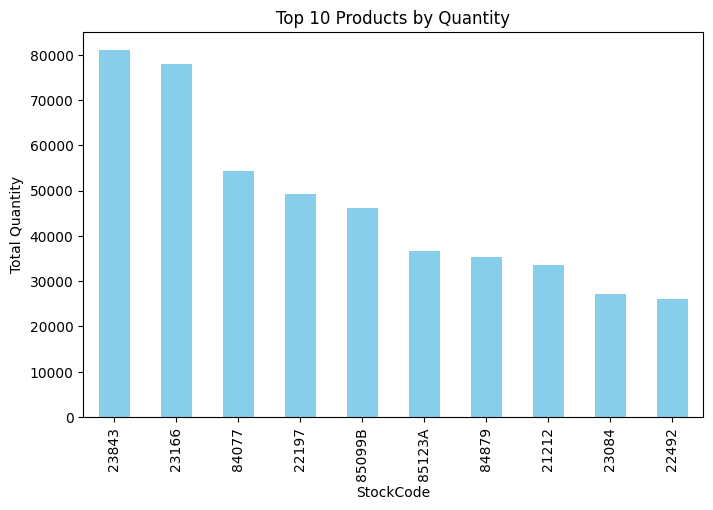

In [27]:
# Top 10 Products by Quantity
top_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 5))
top_products.plot(kind='bar', color='skyblue')
plt.title("Top 10 Products by Quantity")
plt.xlabel("StockCode")
plt.ylabel("Total Quantity")
plt.show()

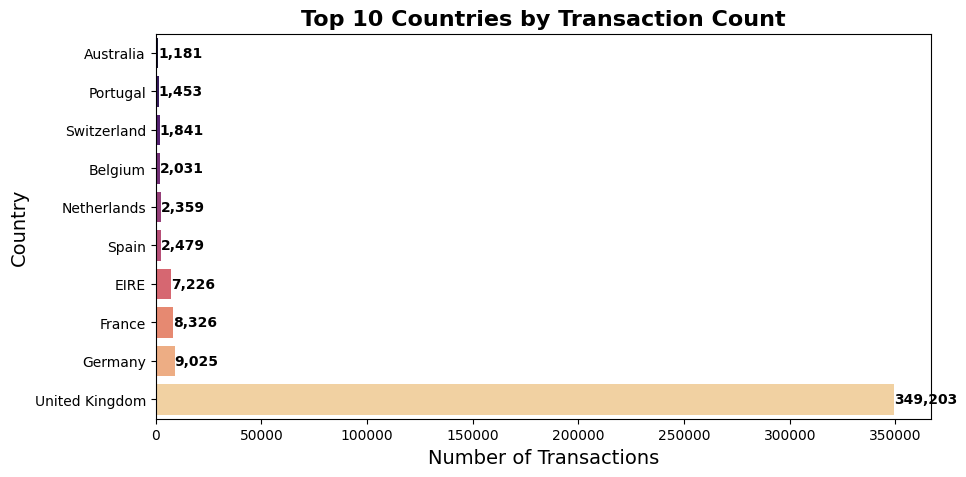

In [28]:
# Country-wise Sales Count (Top 10 Countries)
plt.figure(figsize=(10, 5))
top_countries = df['Country'].value_counts().nlargest(10).sort_values(ascending=True)

# Horizontal bar plot for better readability
sns.barplot(y=top_countries.index, x=top_countries.values, palette="magma")

# Add title and labels
plt.title("Top 10 Countries by Transaction Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Transactions", fontsize=14)
plt.ylabel("Country", fontsize=14)

# Add value labels to each bar
for index, value in enumerate(top_countries.values):
    plt.text(value, index, f"{value:,}", va='center', ha='left', fontweight='bold')

plt.show()


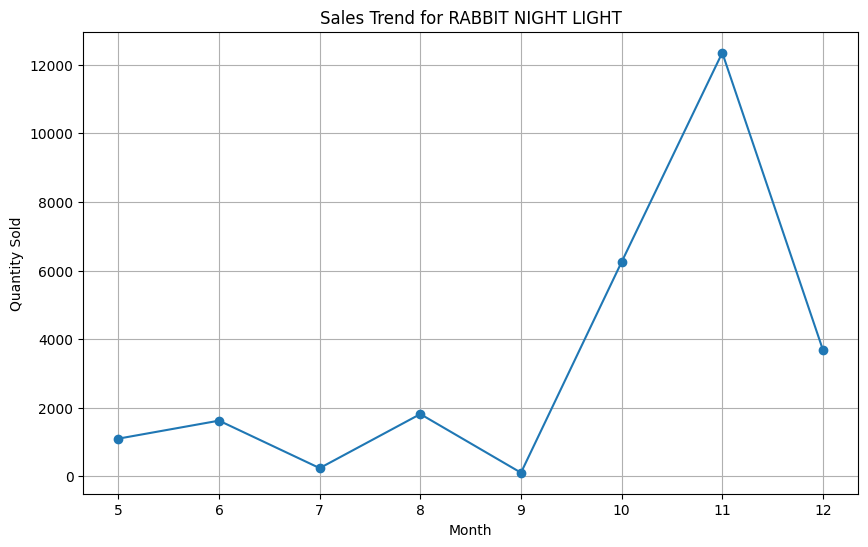

In [29]:
# Group by product and month, summing quantities sold
monthly_sales = df.groupby(['Month', 'Description'])['Quantity'].sum().reset_index()

# --- Line Plot for a Specific Product ---
product = "RABBIT NIGHT LIGHT"  # Replace with your product of interest
product_sales = monthly_sales[monthly_sales['Description'] == product]

plt.figure(figsize=(10, 6))
plt.plot(product_sales['Month'].astype(str), product_sales['Quantity'], marker='o')
plt.title(f'Sales Trend for {product}')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid()
plt.show()

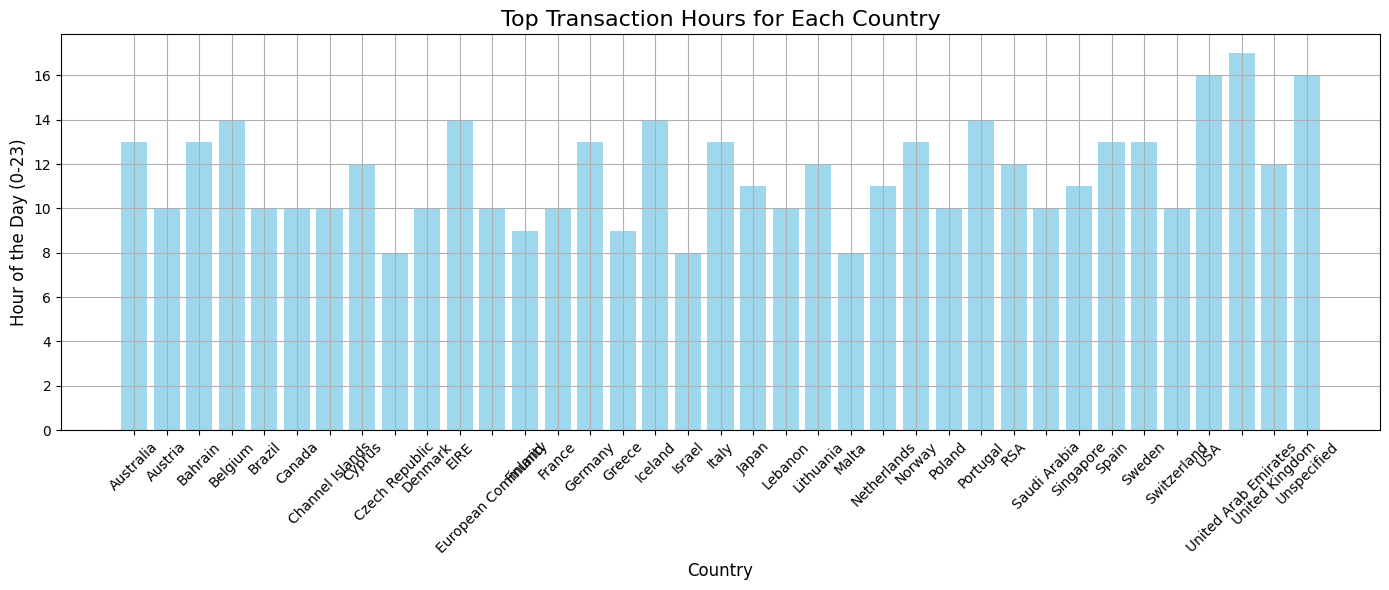

In [30]:
# Extract the hour from the InvoiceDate
df['Hour'] = df['InvoiceDate'].dt.hour
# Group by Country and Hour to count transactions
hourly_transactions = df.groupby(['Country', 'Hour']).size().reset_index(name='TransactionCount')

# Find the hour with the highest transaction count for each country
top_hours = hourly_transactions.loc[hourly_transactions.groupby('Country')['TransactionCount'].idxmax()]

# Plotting the top transaction hours for each country
plt.figure(figsize=(14, 6))
plt.bar(top_hours['Country'], top_hours['Hour'], color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Top Transaction Hours for Each Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Hour of the Day (0-23)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

In [63]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,PriceCategory,WeekDay,Day,Month,Year,TotalAmount,Hour,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,15.30,Low Price,5,1,12,2010,15.30,8,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,Low Price,5,1,12,2010,20.34,8,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,35,22.00,Low Price,5,1,12,2010,22.00,8,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,Low Price,5,1,12,2010,20.34,8,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,Low Price,5,1,12,2010,20.34,8,373


In [31]:
# Calculate Monetary (total spending per customer)
monetary = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Calculate Frequency (number of transactions per customer)
frequency = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Merge the two DataFrames on 'CustomerID'
rfm = pd.merge(monetary, frequency, on='CustomerID',how='inner')

recent_date = max(df['InvoiceDate'])
df['Difference'] = (recent_date - df['InvoiceDate']).dt.days
recency = df.groupby('CustomerID')['Difference'].min()
recency = recency.reset_index()

final_rfm = pd.merge(rfm,recency,on='CustomerID',how='inner')
final_rfm.columns = ['CustomerID','monetary','Frequency','Recency']


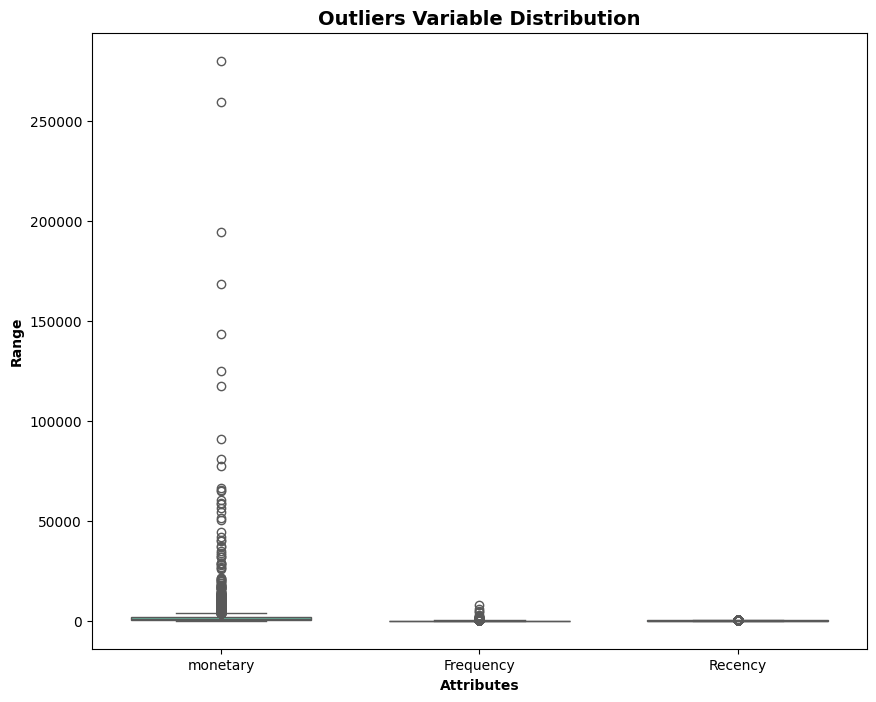

In [32]:
attributes = ['monetary','Frequency','Recency']
# Set the figure size
plt.rcParams['figure.figsize'] = [10, 8]

# Create the box plot
sns.boxplot(data=final_rfm[attributes], orient="v", palette="Set2", saturation=1, width=0.7)

# Set the title and labels with styling
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight="bold")
plt.xlabel("Attributes", fontweight="bold")

# Display the plot
plt.show()

In [33]:
# Function to remove statistical outliers based on IQR
def remove_outliers(final_rfm, column):
    Q1 = final_rfm[column].quantile(0.05)
    Q3 = final_rfm[column].quantile(0.95)
    IQR = Q3 - Q1
    return final_rfm[(final_rfm[column] >= Q1 - 1.5 * IQR) & (final_rfm[column] <= Q3 + 1.5 * IQR)]

# Remove outliers for Amount, Recency, and Frequency
rfm = remove_outliers(final_rfm, 'monetary')
rfm = remove_outliers(final_rfm, 'Recency')
rfm = remove_outliers(final_rfm, 'Frequency')

# Display the updated DataFrame
rfm

,CustomerID,monetary,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4333,18280.0,180.60,10,277
4334,18281.0,80.82,7,180
4335,18282.0,178.05,12,7
4336,18283.0,2045.53,721,3


In [34]:
from sklearn.preprocessing import StandardScaler
rfm_df = rfm[['monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4309, 3)

In [35]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['monetary', 'Frequency', 'Recency']
rfm_df_scaled

,monetary,Frequency,Recency
0,10.689355,-0.752318,2.326789
1,0.355086,1.008132,-0.910294
2,-0.001251,-0.460531,-0.180951
3,-0.006879,-0.052028,-0.740447
4,-0.208697,-0.596698,2.166934
...,...,...,...
4304,-0.230508,-0.664782,1.847222
4305,-0.244658,-0.693961,0.878095
4306,-0.230869,-0.645329,-0.850348
4307,0.033960,6.250579,-0.890312


In [36]:
from sklearn.cluster import KMeans
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

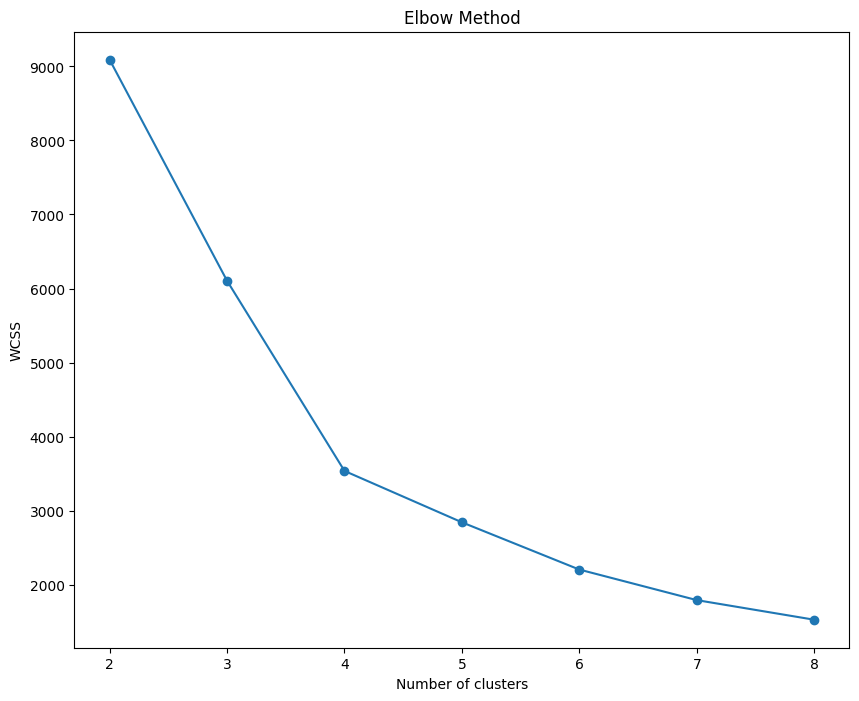

In [37]:
# Assuming rfm_df_scaled is your scaled dataset
# Calculate WCSS for different values of K
wcss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=0)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

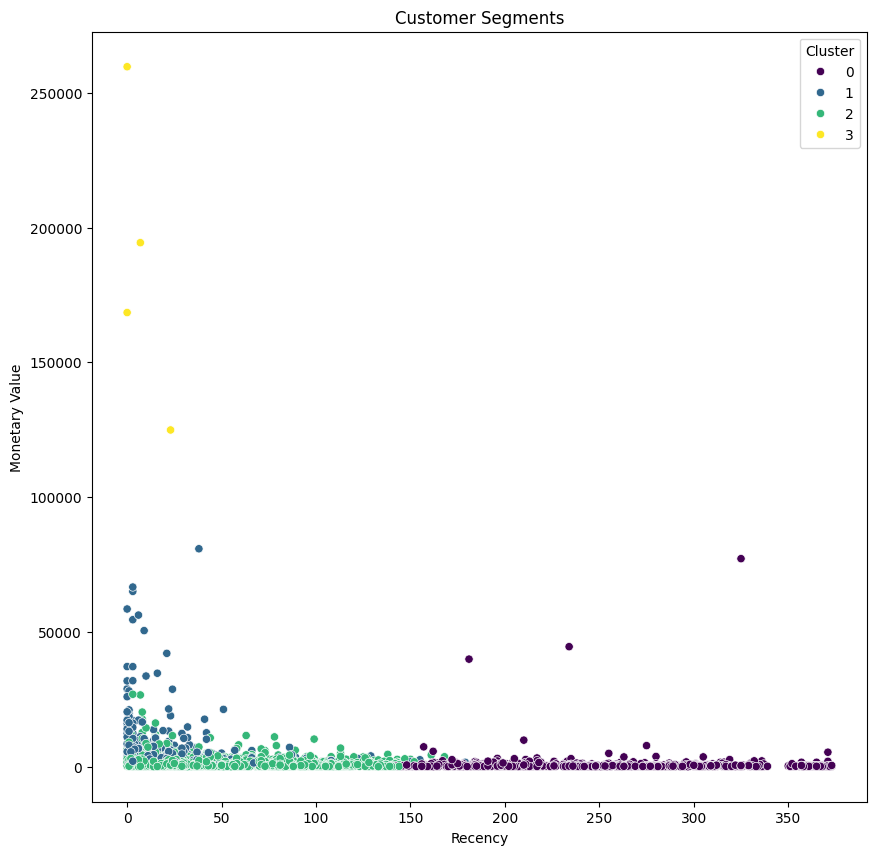

In [38]:
# Fit K-Means with optimal number of clusters (replace 4 with your chosen number)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

rfm['Cluster'] = kmeans.fit_predict(rfm_df_scaled)
plt.figure(figsize=(10, 10))
sns.scatterplot(x='Recency', y='monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.legend(title='Cluster')
plt.show()

### recommendations for rfm(4 clusters)
#### Cluster 0: Re-engage inactive customers with tailored offers and gather their feedback to improve.
#### Cluster 1: Recognize and reward loyal customers with exclusive perks and premium recommendations.
#### Cluster 2: Encourage consistent customers to increase spending through attractive deals and reminders.
#### Cluster 3: Provide top spenders with VIP treatment and personalized engagement to retain their loyalty.

In [39]:
# Calculate the mean of each feature for each cluster to get the summary
cluster_summary = rfm.groupby('Cluster')[['monetary', 'Frequency', 'Recency']].mean()

# Print the cluster summary
print(cluster_summary)

              monetary   Frequency     Recency
Cluster                                       
0           624.671371   26.053283  249.014272
1          6910.016232  329.985782   18.189573
2          1222.569034   59.847105   45.016949
3        186858.780000  371.000000    7.500000


In [40]:
rfm

,CustomerID,monetary,Frequency,Recency,Cluster
0,12346.0,77183.60,1,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0
...,...,...,...,...,...
4333,18280.0,180.60,10,277,0
4334,18281.0,80.82,7,180,0
4335,18282.0,178.05,12,7,2
4336,18283.0,2045.53,721,3,1


# predicting Sales trends using RFM data frame 
## Using RandomForest Regression
## Feature Selection 

In [41]:
# Feature Selection (X) and Target (y)
X = rfm[['Recency', 'Frequency', 'Cluster']]
y = rfm['monetary']

In [42]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

## Model creation

In [43]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

## Predicting Values 

In [44]:
# Make predictions
y_pred = rf_model.predict(X_test)

## Evaluate the model

In [45]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Model Performance:
Mean Absolute Error (MAE): 1278.62
Root Mean Squared Error (RMSE): 4035.36
R^2 Score: 0.54


## Visualize Feature Importance

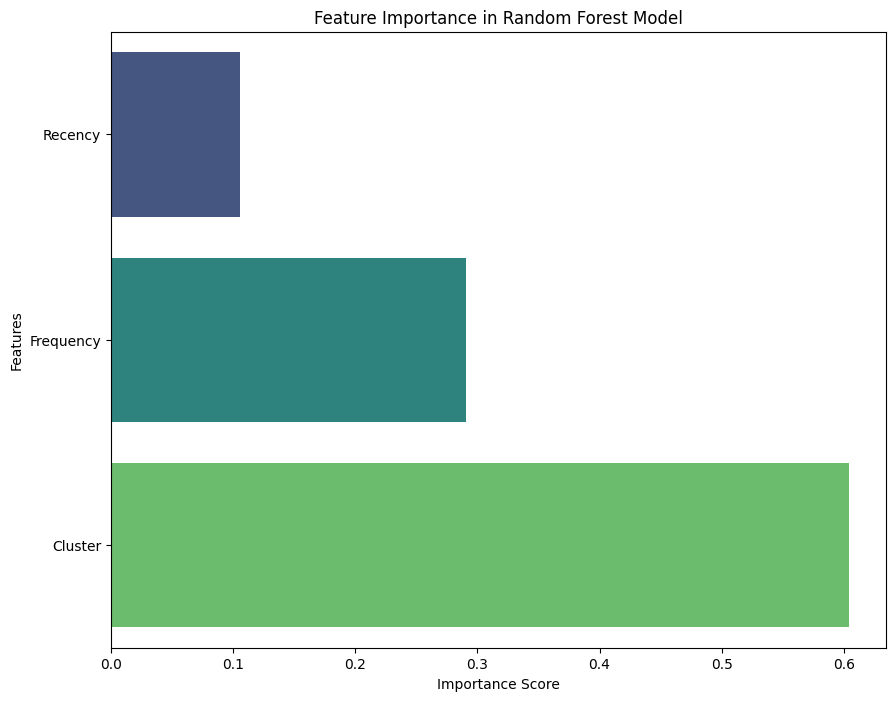

In [46]:
importances = rf_model.feature_importances_
sns.barplot(x=importances, y=X.columns, palette='viridis')
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

## Example Prediction for a New Data Point

In [47]:
# Replace with actual input values: [Recency, Frequency, Cluster]
new_data = [[30, 5, 2]]  
predicted_sales = rf_model.predict(new_data)
print(f"Predicted Sales for the input {new_data}: {predicted_sales[0]:.2f}")

Predicted Sales for the input [[30, 5, 2]]: 224.98


# predicting Sales trends using main data set
## Encode categorical variables (if any)

In [48]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,PriceCategory,WeekDay,Day,Month,Year,TotalAmount,Hour,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Low Price,Wed,1,12,2010,15.30,8,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34,8,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Low Price,Wed,1,12,2010,22.00,8,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34,8,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Low Price,Wed,1,12,2010,20.34,8,373


In [49]:
df['Country'] = df['Country'].astype('category').cat.codes
df['WeekDay'] = df['WeekDay'].astype('category').cat.codes

## Select features and target variable

In [50]:
features = ['Quantity', 'UnitPrice', 'Month', 'Day', 'WeekDay']
target = 'TotalAmount'
X = df[features]
y = df[target]

## Split data into training and test sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Random Forest Regressor

In [52]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Make predictions on the test set

In [53]:
y_pred = rf_model.predict(X_test)

## Evaluate the model

In [54]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Model Evaluation:
Mean Absolute Error (MAE): 1.83
Root Mean Squared Error (RMSE): 426.91
R^2 Score: 0.50


## Feature Importance

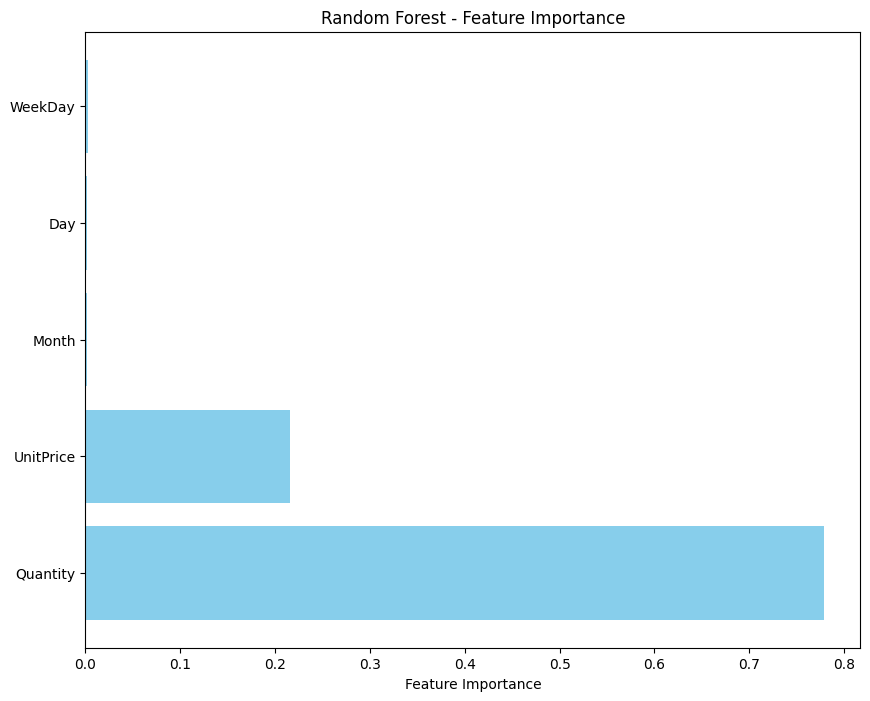

In [55]:
importances = rf_model.feature_importances_
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

##  Example predictions (show first few predicted sales)

In [56]:
print(f"Predicted sales for the first few test samples: {y_pred[:5]}")

Predicted sales for the first few test samples: [17.7  9.9 30.  13.2 19.8]


# Support Vector Regression

In [57]:
from sklearn.svm import SVR
X = rfm[['Recency', 'Frequency', 'Cluster']]  
y = rfm['monetary']  

## Train-Test Split



In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Scaling (SVR requires features to be scaled)

In [59]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Model Training - Support Vector Regression (SVR)

In [60]:
svr_model = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.1) 
svr_model.fit(X_train_scaled, y_train)

SVR(C=100, gamma='auto')

## Predicting the values

In [61]:
y_pred = svr_model.predict(X_test_scaled)

## Evaluate the model

In [62]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 1122.86
Root Mean Squared Error (RMSE): 4879.54
R² Score: 0.10
